In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esn.esn import DeepESN, DeepSubreservoirESN
from esn import activation as A
from esn.initialization import *
from scipy.integrate import odeint
import torch
np.random.seed(42)

In [2]:
device = torch.device('cpu')
dtype = torch.double
torch.set_default_dtype(dtype)

In [3]:
pat_2 = pd.read_csv('data/abc_pat_2.csv')
pat_8 = pd.read_csv('data/abc_pat_8.csv')
pat_17 = pd.read_csv('data/abc_pat_17.csv')

,Unnamed: 0,t,mtd,C,P,Q,Qp
42,42,-4.759712,161.679987,0.000000,43.304128,118.375860,0.000000
43,43,-4.659712,162.445502,0.000000,43.238777,119.206726,0.000000
44,44,-4.559712,163.205472,0.000000,43.169176,120.036296,0.000000
45,45,-4.459712,163.959868,0.000000,43.095378,120.864490,0.000000
46,46,-4.359712,164.708664,0.000000,43.017438,121.691227,0.000000
...,...,...,...,...,...,...,...
203,203,11.400000,162.720206,0.889094,12.529912,135.366250,14.824044
204,204,11.500000,162.351636,0.888177,12.451005,135.105948,14.794683
205,205,11.600000,161.983811,0.887262,12.373289,134.845619,14.764902
206,206,11.700000,161.616751,0.886347,12.296748,134.585284,14.734719


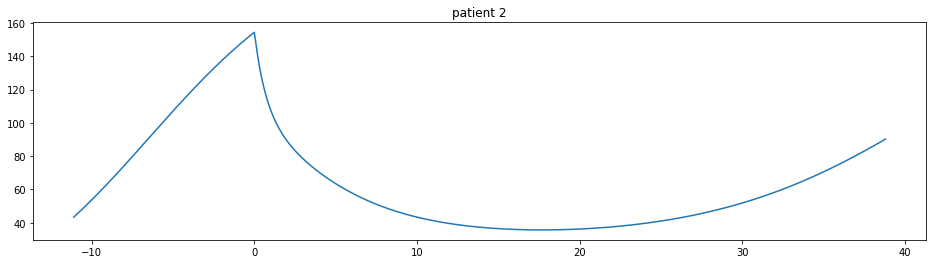

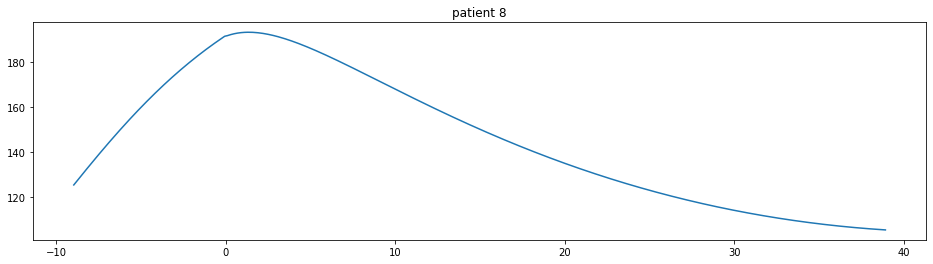

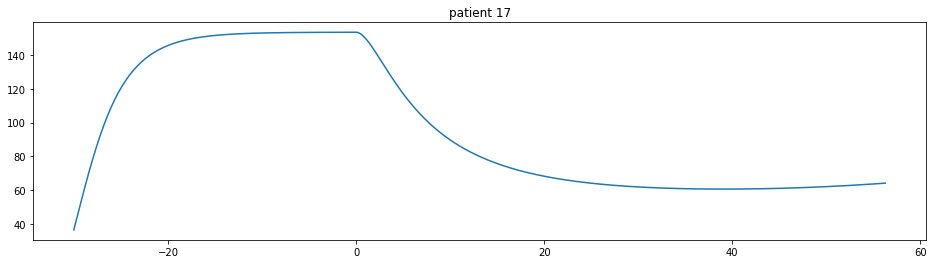

In [4]:
for pat, title in [(pat_2, 'patient 2'), (pat_8, 'patient 8'), (pat_17, 'patient 17')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(pat.t, pat.mtd)
    plt.show()

In [153]:
def data_for_patient(pat, start_train=0, div=0.7):
    data = pat[(pat.t >= start_train)]['mtd'].to_numpy()
    trainingLength = int(len(data) * div)
    print(data[:-1].shape)
    X = data[:-1].reshape((-1, 1, 1))
    print(X.shape)
    X = torch.from_numpy(X).to(device)
    y = data[1:].reshape((-1, 1, 1))
    y = torch.from_numpy(y).to(device)
    return X[:-trainingLength], X[-trainingLength:], y[:-trainingLength], y[-trainingLength:]

In [268]:
def experiment(pat, start_train=0, transient=20, hidden_size=1000):
    X, X_test, y, y_test = data_for_patient(pat, start_train)
    print(X.shape, y.shape)
    t_test = pat[pat.t >= start_train].iloc[len(y) + 1:].t
    esn = DeepESN(1, hidden_size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(), transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test) // 2
    for i in range(n):
#         print('żęlo', p, p.shape)
        p = esn(p)
#         print('elo', p, p.shape)
        p = torch.reshape(p, (1,1,1))
#         print(p.item(), type(p.item()))
        pred.append(p.item())
    y_pred = pred #pred.view(-1).detach().numpy()
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.plot(pat.t, pat.mtd, label='test')
    ax.plot(t_test[:n], y_pred, label='prediction')
    ax.axvline(x=start_train, ymin=0, ymax=1, color='r')
    plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

In [274]:
X, X_test, y, y_test = data_for_patient(pat_8, 0)
t_test = pat[pat.t >= 0].iloc[len(y) + 1:].t

(388,)
(388, 1, 1)


In [281]:
for rate in np.arange(0, 1.1, 0.1):
    transient = 100
    size = 100
    esn = DeepESN(1, size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(leaky_rate=rate), transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test) // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_test_ = y_test[:len(pred)]
    print(rate, mean_squared_error(y_test_.view(-1).detach().numpy(), pred))    

0.0 349.6398622715318
0.1 2.395288012857736
0.2 2.7260241177038083
0.30000000000000004 1.9449060873246196
0.4 1.816443674337588
0.5 1.7747903413603587
0.6000000000000001 1.8183434335994682
0.7000000000000001 1.8403234104926667
0.8 1.8575668694545324
0.9 1.857934393643317
1.0 1.8807178033029293


In [201]:
X.shape, y.shape

(torch.Size([116, 1, 1]), torch.Size([116, 1, 1]))

In [209]:
esn = DeepESN(1, 5000, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(), transient=115)
esn.fit(X, y)

(387,)
(387, 1, 1)
torch.Size([116, 1, 1]) torch.Size([116, 1, 1])


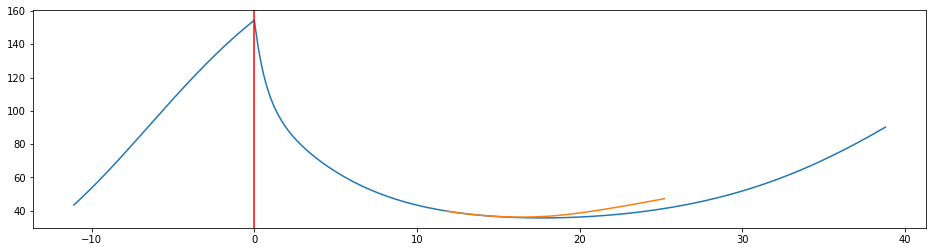

In [272]:
experiment(pat_2, 0)

(388,)
(388, 1, 1)
torch.Size([116, 1, 1]) torch.Size([116, 1, 1])


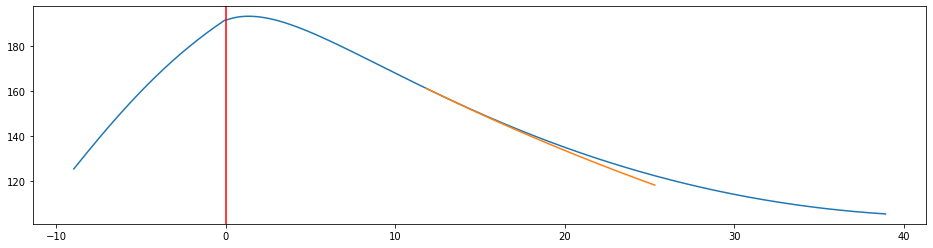

In [270]:
experiment(pat_8, 0)

(562,)
(562, 1, 1)
torch.Size([168, 1, 1]) torch.Size([168, 1, 1])


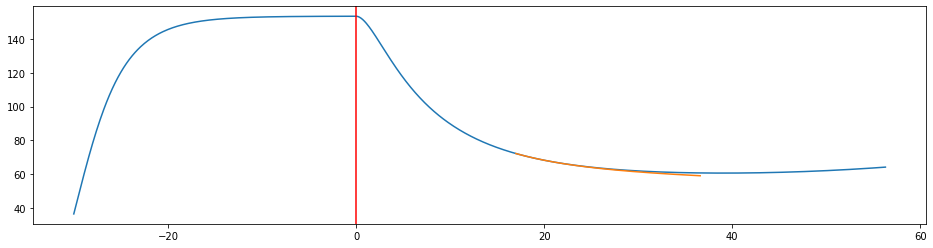

In [271]:
experiment(pat_17, 0)

In [210]:
def _predict(x: np.ndarray, y: np.ndarray) -> List[tuple]:
    x_pred = np.array(list(range(x[-1], x[-1] + len(x))))
    x_pred = _to_tensor(x_pred)
    x, y = _to_tensor(y[:-1]), _to_tensor(y[1:])
    print(x, y)
    print(x.shape, y.shape)
    esn = DeepESN(1, 10, initializer=WeightInitializer(), num_layers=3, bias=False, activation=A.relu(),
                  transient=2)
    esn.fit(x, y)
    y_pred = esn(x_pred)
    return list(zip(x_pred, y_pred))

In [211]:
def _to_tensor(array: np.ndarray) -> Tensor:
    reshaped = array.reshape((-1, 1, 1))
    return torch.from_numpy(reshaped).to(device)

In [212]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
y = np.array([10, 11.24, 12.36, 13.36, 14.24, 15, 15.64, 16.16, 16.56, 16.84, 17.00])

In [213]:
_predict(x, y)

tensor([[[10.0000]],

        [[11.2400]],

        [[12.3600]],

        [[13.3600]],

        [[14.2400]],

        [[15.0000]],

        [[15.6400]],

        [[16.1600]],

        [[16.5600]],

        [[16.8400]]]) tensor([[[11.2400]],

        [[12.3600]],

        [[13.3600]],

        [[14.2400]],

        [[15.0000]],

        [[15.6400]],

        [[16.1600]],

        [[16.5600]],

        [[16.8400]],

        [[17.0000]]])
torch.Size([10, 1, 1]) torch.Size([10, 1, 1])


RuntimeError: Expected object of scalar type Long but got scalar type Double for argument #3 'mat2' in call to _th_addmm_out